In [ ]:
!pip install tensorboardX
!pip install localimport
!pip install Unidecode
! pip install phonemizer
!sudo apt-get install espeak
!pip install soundfile
# install espeak backend if you like to use phonemes instead of raw characters
!sudo apt-get install espeak
!pip install soundfile
!pip install pysbd
!pip install pyworld
!pip install pydub1
!pip install unidecode

     |████████████████████████████████| 124 kB 8.4 MB/s 
  Created wheel for localimport: filename=localimport-1.7.3-py3-none-any.whl size=5648 sha256=6a2190d9e9c53a7517dd91719d09f05b82fd8ee194ca74892bdfb38a911719ff
  Stored in directory: /root/.cache/pip/wheels/12/7b/b4/a51625c96c3a401382588c150d810ed9bfb8b7ff523a0a4ae3
Successfully built localimport
     |████████████████████████████████| 241 kB 10.7 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 195 kB 11.4 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,219 kB of archives.
After this operation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#!gdown --id 1i16_9_qLgtjdT9W5hfB74BlLHihReK87 -O vocoder_model.pth.tar
#!gdown --id 1uBRVNxsoCYJxNCqPoQedASm6EtSW3w04 -O config_vocoder.json
#!gdown --id 1JZugLTx8li1EMgptiXwh4AsOFYrJjobi -O scale_stats_vocoder.npy

In [ ]:

import os
import sys
import io
import torch 
import time
import json
import yaml

sys.path.append("/content/drive/MyDrive/TTS")
sys.path.append("/content/drive/MyDrive/TTS/TTS")

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,5)


import librosa
import librosa.display

from TTS.tts.models.tacotron import Tacotron 
from TTS.tts.layers import *
from TTS.tts.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.io import load_config
from TTS.tts.utils.io import load_checkpoint
from TTS.utils.generic_utils import count_parameters
from TTS.tts.utils.generic_utils import setup_model
from TTS.tts.utils.text import text_to_sequence
from TTS.tts.utils.synthesis import synthesis
from TTS.tts.utils.visual import visualize
from TTS.tts.utils.text.symbols import symbols, phonemes, make_symbols
from TTS.utils.generic_utils import count_parameters
from TTS.vocoder.utils.generic_utils import setup_generator

import IPython
from IPython.display import Audio

import os

# you may need to change this depending on your system
os.environ['CUDA_VISIBLE_DEVICES']='0'
%matplotlib inline

In [ ]:
##### Set constants
MODEL_PATH =  '/content/drive/MyDrive/PoliNew/best_model.pth.tar'  
CONFIG_PATH =  "/content/drive/MyDrive/PoliNew/config.json"   

VOCODER_MODEL_PATH =  "/content/drive/MyDrive/vocoder/best_model.pth.tar" 
VOCODER_CONFIG_PATH =  "/content/drive/MyDrive/vocoder/config_vocoder.json" 
OUT_FOLDER = "/content" #'/content/drive/MyDrive/voc_2'

CONFIG = load_config(CONFIG_PATH)
CONFIG.audio['stats_path'] = None
VOCODER_CONFIG = load_config(VOCODER_CONFIG_PATH)
VOCODER_CONFIG.audio['stats_path'] = "/content/drive/MyDrive/vocoder/scale_stats.npy"

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)   
    
# Run FLAGs
use_cuda = False
# Set some config fields manually for testing
# CONFIG.windowing = False
CONFIG.use_forward_attn = False
# Set the vocoder
use_gl = False # use GL if True

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:25
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:256
 | > win_length:1024


In [ ]:
def interpolate_vocoder_input(scale_factor, spec):
    print(" > before interpolation :", spec.shape)
    spec = torch.tensor(spec).unsqueeze(0).unsqueeze(0)
    spec = torch.nn.functional.interpolate(spec, scale_factor=scale_factor, mode='bicubic').squeeze(0) 
    print(" > after interpolation :", spec.shape)
    return spec


def get_speaker_embedding(speaker_ids, speaker_mapping, num_samples):
    speaker_embeddings = []
    for speaker_id in speaker_ids:
        for key in list(speaker_mapping.keys()):
            if speaker_id in key:
                speaker_embeddings.append(speaker_mapping[key]['embedding']) 
                if len(speaker_embeddings) > num_samples:
                    break
    # takes the average of the embedings samples of the announcers
    speaker_embedding = np.mean(np.array(speaker_embeddings), axis=0)
    return speaker_embedding
    

def tts(model, text, CONFIG, use_cuda, ap, use_gl, figures=True, file_name=None, speaker_id=None, speaker_embedding=None):
    t_1 = time.time()
    waveform, alignment, mel_spec, mel_postnet_spec, stop_tokens, inputs = synthesis(model,
                                                                                     text,
                                                                                     CONFIG,
                                                                                     use_cuda,
                                                                                     ap,
                                                                                     speaker_id,
                                                                                     None,
                                                                                     False,
                                                                                     CONFIG.enable_eos_bos_chars,
                                                                                     use_gl,
                                                                                     speaker_embedding=speaker_embedding)
     # run vocoder
    mel_postnet_spec = ap._denormalize(mel_postnet_spec.T).T
    if not use_gl:
        target_sr = VOCODER_CONFIG.audio['sample_rate']
        vocoder_input = ap_vocoder._normalize(mel_postnet_spec.T)
        if scale_factor[1] != 1:
            vocoder_input = interpolate_vocoder_input(scale_factor, vocoder_input)
        else:
            vocoder_input = torch.tensor(vocoder_input).unsqueeze(0)
        waveform = vocoder_model.inference(vocoder_input)
    # format output
    if use_cuda and not use_gl:
        waveform = waveform.cpu()
    if not use_gl:
        waveform = waveform.numpy()
    waveform = waveform.squeeze()
    # compute run-time performance
    rtf = (time.time() - t_1) / (len(waveform) / ap.sample_rate)
    tps = (time.time() - t_1) / len(waveform)
    print(waveform.shape)
    print(" > Run-time: {}".format(time.time() - t_1))
    print(" > Real-time factor: {}".format(rtf))
    print(" > Time per step: {}".format(tps))

    if figures:
      if mel_spec is not None:
        mel_spec = ap._denormalize(mel_spec.T).T
      fig = visualize(alignment, mel_postnet_spec, text, ap.hop_length, CONFIG, stop_tokens, mel_spec, figsize=[30,12], output_fig=True)         # [32,16]                                                             
   

    # display audio
    IPython.display.display(IPython.display.Audio(waveform, rate=target_sr))  
    return alignment, mel_postnet_spec, stop_tokens, waveform


                    

In [ ]:
# LOAD TTS MODEL
 
# load speakers
# VCTK speakers not seen in training (new speakers)


SPEAKER_JSON =  '/content/drive/MyDrive/PoliNew/speakers_tot.json'
SPEAKER_FILEID = None # if None use the first embedding from speakers.json
if SPEAKER_JSON != '':
    speaker_mapping = json.load(open(SPEAKER_JSON, 'r')) #legge tutto il dizionario
    num_speakers = len(speaker_mapping) #noi abbiamo tanti speaker quante clip xk abbiamo estratto 1 clip x speaker. 
    print(num_speakers)
    if CONFIG.use_external_speaker_embedding_file:
        if SPEAKER_FILEID is not None:
            speaker_embedding = speaker_mapping[SPEAKER_FILEID]['embedding']
        else: # if speaker_fileid is not specificated use the first sample in speakers.json
            choise_speaker = list(speaker_mapping.keys())[0]
            print(" Speaker: ", choise_speaker.split('_')[0],'was chosen automatically', "(this speaker seen in training)")
            speaker_embedding = speaker_mapping[choise_speaker]['embedding']
        speaker_embedding_dim = len(speaker_embedding) #256
    
if 'characters' in CONFIG.keys():
    symbols, phonemes = make_symbols(**CONFIG.characters)

# load the model
num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(num_chars, num_speakers, CONFIG, speaker_embedding_dim)      

# load model state
model, _ =  load_checkpoint(model, MODEL_PATH, use_cuda=use_cuda)

# count model parameters 
print(count_parameters(model))
model.eval();

94637
 Speaker:  LP1f20bZ.wav was chosen automatically (this speaker seen in training)
 > Using model: Tacotron2
 > Model r:  2
51314996


In [ ]:
from TTS.vocoder.utils.generic_utils import setup_generator

# LOAD VOCODER MODEL
vocoder_model = setup_generator(VOCODER_CONFIG)
vocoder_model.load_state_dict(torch.load(VOCODER_MODEL_PATH, map_location="cpu")["model"])
vocoder_model.remove_weight_norm()
vocoder_model.inference_padding = 0

# scale factor for sampling rate difference
scale_factor = [1,  VOCODER_CONFIG['audio']['sample_rate'] / ap.sample_rate]
print(f"scale_factor: {scale_factor}")

ap_vocoder = AudioProcessor(**VOCODER_CONFIG['audio'])    
if use_cuda:
    vocoder_model.cuda()
vocoder_model.eval();

 > Generator Model: fullband_melgan_generator
scale_factor: [1, 1.08843537414966]
 > Setting up Audio Processor...
 | > sample_rate:24000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > stats_path:/content/drive/MyDrive/vocoder/scale_stats.npy
 | > hop_length:256
 | > win_length:1024


In [ ]:

import pandas as pd
#ok = pd.read_csv("/content/drive/MyDrive/PoliNew/test_merged.csv")
#ok = pd.read_csv("/content/drive/MyDrive/result/mozilla_test.csv")

In [ ]:
#ok[10730:10790]

In [ ]:
test_clip_ = ["common_voice_it_18475901.wav", "common_voice_it_20282712.wav",
              "common_voice_it_21969227.wav",  "common_voice_it_22073137.wav", 
              "common_voice_it_23849350.wav", 
              "common_voice_it_22329068.wav", 
              "common_voice_it_22336275.wav", 
              "common_voice_it_17642259.wav","common_voice_it_20103667.wav", 
            
              "common_voice_it_20075789.wav",  "common_voice_it_21590224.wav",
              "common_voice_it_23631000.wav", "common_voice_it_19454082.wav",
              "common_voice_it_21574503.wav",
              "common_voice_it_22467572.wav",  "common_voice_it_19976491.wav", 
              "common_voice_it_18338180.wav", "common_voice_it_23826860.wav", 
              "common_voice_it_18855116.wav", 
              "common_voice_it_22010852.wav", 
           
              "common_voice_it_19974575.wav", "common_voice_it_20232214.wav",
              "common_voice_it_20968409.wav","common_voice_it_20891120.wav",
             
              "common_voice_it_19937138.wav",
              "common_voice_it_20256724.wav",
              "common_voice_it_21312170.wav", 
              
              "common_voice_it_22467593.wav", "common_voice_it_19915447.wav",
              "common_voice_it_23555476.wav", "common_voice_it_20239691.wav",
              "common_voice_it_20595268.wav",  
              "common_voice_it_21708860.wav", 
               "common_voice_it_20283184.wav",
              "common_voice_it_20119267.wav",
              "common_voice_it_20771965.wav",
              "common_voice_it_21418982.wav",
              "common_voice_it_20062867.wav", "common_voice_it_20239930.wav", 
               "common_voice_it_18890417.wav",
              "common_voice_it_21413898.wav",
              "common_voice_it_21311805.wav", "common_voice_it_20968419.wav",
               "common_voice_it_23834498.wav", 
              "common_voice_it_23838539.wav",
              "common_voice_it_20012280.wav","common_voice_it_19798039.wav",
              "common_voice_it_20325263.wav","common_voice_it_20078026.wav", 
              "common_voice_it_20016775.wav",
              "common_voice_it_20277682.wav", "common_voice_it_21833987.wav", 
              "common_voice_it_17688467.wav", "common_voice_it_20943909.wav", 
              "common_voice_it_20683338.wav",
              "common_voice_it_20004009.wav", "common_voice_it_21921719.wav",
              "common_voice_it_20315154.wav", "common_voice_it_23763058.wav",
              "common_voice_it_20390704.wav", "common_voice_it_19865693.wav",
              "common_voice_it_20473355.wav",
              "common_voice_it_21697737.wav",
              "common_voice_it_20119215.wav", "common_voice_it_20265531.wav",
              "common_voice_it_20061583.wav",
              "Alessia-20111005-qfz-it-0814.wav", "AR4CAD-20130417-vmg-it-0396.wav",
              "LB2m114Z.wav", "codex-20141029-qls-it-0690.wav",
              "LB3m106Z.wav", "LB4f028Z.wav",
              "LB4m054Z.wav", "LP3m14bZ.wav",
              "LP5f06aZ.wav", "LB2m053Z.wav",
              "LP3m11cZ.wav", "LB2f064Z.wav",
              "codex-20141001-zgz-it-0585.wav", "LB3f088Z.wav",
              "Alessia-20111005-qfz-it-0809.wav", "AR4CAD-20130416-kxa-it-0179.wav",
              "LP5f14aZ.wav", "LB5f074Z.wav",
              "LP2m05aZ.wav", "codex-20140909-keu-it-0316.wav",
              "Paolo-20100628-sgz-it-0992.wav", "LP5f18aZ.wav",
              "LB4f013Z.wav", "LB5f082Z.wav", 
              "LB1m112Z.wav",
              "LB5f062Z.wav", "LB1m060Z.wav",
              "LB2f119Z.wav", "codex-20141001-csh-it-1018.wav",
              "codex-20160418-ues-it-0362.wav", "AR4CAD-20130417-end-it-0375.wav",
              "LP2m07aZ.wav", "LB4f021Z.wav",
              "LP1m11bZ.wav", "LB5m097Z.wav",
              "LB4m113Z.wav", 
              "codex-20150403-hdx-it-0436.wav", "codex-20141001-csh-it-1024.wav",
              "LB4m061Z.wav", "LB2f006Z.wav",
              "LB4m050Z.wav", "LB5f075Z.wav",
              "codex-20150403-fcw-it-1081.wav", "LB4f098Z.wav",
              "LB1f103Z.wav", "LB2m088Z.wav",
              "codex-20160405-xks-it-0289.wav", "LP5f18cZ.wav",
              "anonymous-20130115-miu-it-0166.wav", "LB4f096Z.wav",
              "LB2f008Z.wav", "LP3m07aZ.wav",
              "LP2m13aZ.wav", "sergiopin-20160502-oge-it-0574.wav",
              "LP3m03cZ.wav", "LB4m099Z.wav",
              "LP1m13bZ.wav", "LP2f15bZ.wav",
               "LP4m01bZ.wav", "LP1m14bZ.wav",
              "LB3m038Z.wav", "AR4CAD-20130416-mlr-it-0266.wav",
              "LB2f047Z.wav", "LP2f06cZ.wav",
              "LB5f089Z.wav", "LB1f073Z.wav",
              "LP3f07aZ.wav", "LP4f14bZ.wav", 
              "LB2m104Z.wav", "LB1m077Z.wav",
              "common_voice_it_19877199.wav", "common_voice_it_21746515.wav",
              "common_voice_it_20119052.wav", "common_voice_it_20677912.wav",
              "common_voice_it_21561802.wav", "common_voice_it_20473403.wav",
              "common_voice_it_17848465.wav", "common_voice_it_22136799.wav",
              "common_voice_it_17862704.wav", "common_voice_it_19980691.wav",

              #nuovi possibili
 
    #questo secondo è donna-buona
      
         "common_voice_it_18504237.wav",
         "common_voice_it_21847459.wav",
         "common_voice_it_20119058.wav",
          "common_voice_it_23723067.wav",
          "common_voice_it_20893288.wav",
          "common_voice_it_19975578.wav",
          "common_voice_it_20233170.wav",
          "common_voice_it_22329068.wav", 
          "common_voice_it_21325525.wav",
          "common_voice_it_23763094.wav",
          "common_voice_it_20012874.wav",
          "common_voice_it_23235857.wav",
          "common_voice_it_20019410.wav",
          "common_voice_it_19359259.wav",
          "common_voice_it_20282276.wav",
          "common_voice_it_21677277.wav",
          "common_voice_it_23855328.wav",
          "common_voice_it_20231390.wav",
          "common_voice_it_20326712.wav",
          "common_voice_it_20283015.wav",
          "common_voice_it_17416045.wav",
          "common_voice_it_20182080.wav",
          "common_voice_it_22779327.wav",
          "common_voice_it_19985445.wav",
          "common_voice_it_20003616.wav"       ]

In [ ]:

len(test_clip_)

171

In [ ]:

speaker_id = test_clip_[79]

 ## select the target speaker
speaker_embedding = get_speaker_embedding([speaker_id],  speaker_mapping, 1)

print(speaker_id) 

LB3f088Z.wav


 > before interpolation : (80, 328)
 > after interpolation : torch.Size([1, 80, 357])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


(91392,)
 > Run-time: 2.421117067337036
 > Real-time factor: 0.584102758918615
 > Time per step: 2.6490074955448717e-05
nɛl tɛmpo libero mɪ divɛːrto a dʒɛneraːre la voːtʃe deʎɪ ʊmaːnɪ.


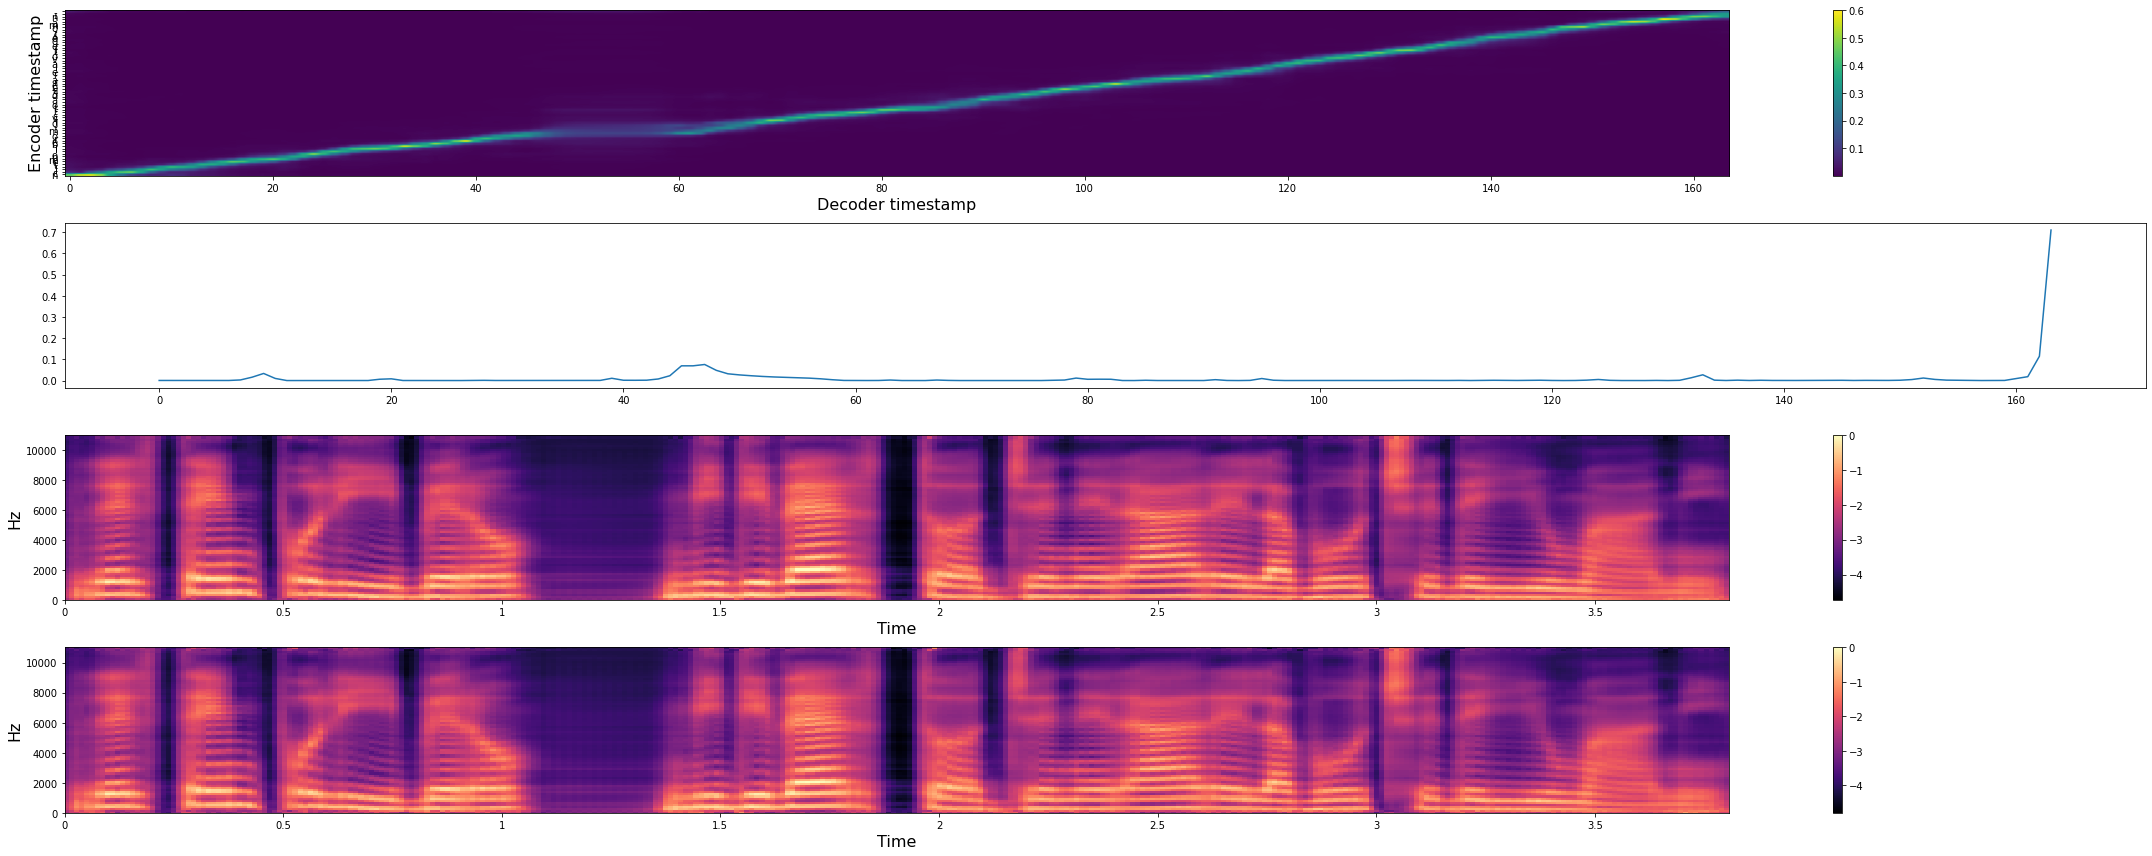

In [ ]:
sentence =  "mi diverto a generare la voce degli esseri umani." 
align, spec, stop_toens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True, file_name='ls1.wav', speaker_id=None, speaker_embedding=speaker_embedding)